In [1]:
#plotting
import seaborn as sns
import math
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from skbio.stats.composition import clr, centralize
from scipy.spatial.distance import euclidean,braycurtis,jaccard
from skbio.stats.composition import clr
from IPython.display import display_html
def display_side_by_side(*args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)
%matplotlib inline

In [2]:
def core(time,maxgrowth=100,level=10):
    return (np.random.normal(size=len(time))//maxgrowth//level)+maxgrowth//level

def random_noise(time,maxgrowth):
    return (np.random.normal(size=len(time))*maxgrowth//20)+maxgrowth

def sigmoid(time):
    return 1/(1+np.exp(-time))

def cos_stable(time, maxgrowth, amp=2, f0=1):
    scale = amp*2
    return (np.cos(amp*np.pi*f0*time)+amp)*maxgrowth//scale

def sin_decay(time, maxgrowth, amp=2, f0=.1, a0=100, tdecay=3):
    return ((np.exp(-time/tdecay)*cos_stable(time,amp,f0,maxgrowth))+ 1)*maxgrowth//2


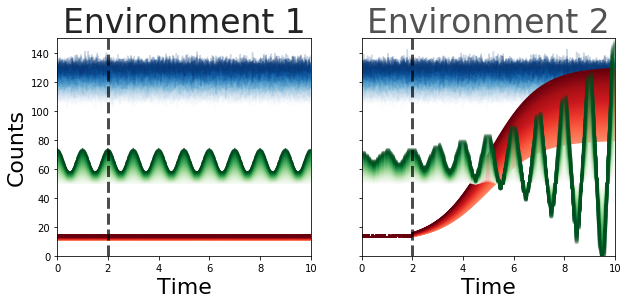

In [430]:

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,4),sharey=True)


maxgrowth=100,
timestep=0.02
timemax=10.
time = np.arange(0,timemax,timestep)
time_sig = np.arange(-timemax//2,timemax//2,timestep)
n_samples = 100

#### env 1 ####
rndH = [i*(random_noise(time,maxgrowth)//2+60) for i in np.linspace(1,1.2,n_samples)]
rndH_c = plt.cm.Blues(np.linspace(0,1,len(rndH)))
for p_,c_ in zip(rndH,rndH_c):
    ax1.plot(time,p_,c=c_,alpha=.2)

sigpn = [(core(time)+2)*i for i in np.linspace(1,1.2,n_samples)]
sigpn_c = plt.cm.Reds(np.linspace(.4,1,len(sigpn)))
for p_,c_ in zip(sigpn,sigpn_c):
    ax1.plot(time,p_,c=c_,alpha=.98)
    
cosn = [i*cos_stable(time,40)+50 for i in np.linspace(0,.8,n_samples)]
cosn_c = plt.cm.Greens(np.linspace(0,1,len(cosn)))
for p_,c_ in zip(cosn,cosn_c):
    ax1.plot(time,p_,c=c_,alpha=.5)
    
ax1.axvline(2,lw=3,ls='--',c='black',alpha=.7)
ax1.set_xlim(0,timemax)
ax1.set_ylim(0,150)
ax1.set_ylabel('Counts',fontsize=22)
ax1.set_xlabel('Time',fontsize=22)
ax1.set_title('Environment 1',fontsize=33,color='#252525')

T_env1 = np.array([[t3,t2,t1] 
                   for t1,t2,t3 in zip(rndH,sigpn,cosn)])


#### env 2 ####
rndH = [i*(random_noise(time,maxgrowth)//2+60) for i in np.linspace(1,1.2,n_samples)]
rndH_c = plt.cm.Blues(np.linspace(0,1,len(rndH)))
for p_,c_ in zip(rndH,rndH_c):
    ax2.plot(time,p_,c=c_,alpha=.2)

sigpn = [np.array(list(sigpn[90][:list(time).index(2.)])+list((sigmoid(time_sig)*i)+10)[list(time).index(2.):])
         for i in np.linspace(int(n_samples//2+20),int(n_samples+20),100)]
sigpn_c = plt.cm.Reds(np.linspace(.4,1,len(sigpn)))
for p_,c_ in zip(sigpn,sigpn_c):
    ax2.plot(time,p_,c=c_,alpha=.98)
    
#range(n_samples//2+20,n_samples+20)

cosn = [i*sin_decay(time,20,amp=.9)[::-1]+50 for i in np.linspace(.1,1.95,n_samples)]
cosn_c = plt.cm.Greens(np.linspace(0,1,len(cosn)))
for p_,c_ in zip(cosn,cosn_c):
    p_[p_<0]=0
    ax2.plot(time,p_,c=c_,alpha=.2,lw=3)

T_env2 = np.array([[t3,t2,t1] 
                   for t1,t2,t3 in zip(rndH,sigpn,cosn)])


ax2.axvline(2,lw=3,ls='--',c='black',alpha=.7)  
ax2.set_xlim(0,timemax)
ax2.set_ylim(0,150)
#ax2.set_ylabel('Counts',fontsize=22)
ax2.set_xlabel('Time',fontsize=22)
ax2.set_title('Environment 2',fontsize=33,color='#525252')

plt.savefig('figures/figure1A.png',dpi=300, 
            bbox_inches='tight', facecolor='white')
plt.show()


In [432]:
from gemelli.tensor_factorization import TenAls
from gemelli.tensor_preprocessing import table_to_tensor,tensor_rclr
from skbio import OrdinationResults, stats
from deicode.optspace import OptSpace
from deicode.preprocessing import rclr


In [433]:
# make toy tensor
Tensor = np.vstack([T_env1,T_env2])
Tensor[Tensor<0]=0
T_rclr = tensor_rclr(Tensor.copy())


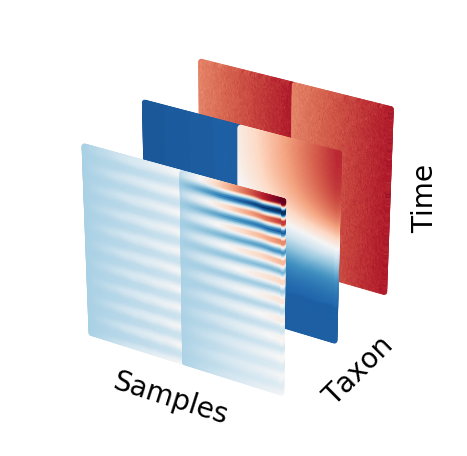

In [446]:
from mpl_toolkits.mplot3d import axes3d
from matplotlib import cm

x = np.arange(Tensor.shape[0])[:, None, None]
y = np.arange(Tensor.shape[1])[None, :, None]
z = np.arange(Tensor.shape[2])[None, None, :]
x, y, z = np.broadcast_arrays(x, y, z)
X = x.ravel()
Y = y.ravel()
Z = z.ravel()
# Do the plotting in a single call.
fig = plt.figure(figsize=(8,8))
ax = fig.gca(projection='3d')
p = ax.scatter(x.ravel(),
           y.ravel(),
           z.ravel(),
           c=Tensor.ravel(),
           cmap=plt.get_cmap('RdBu_r')) #RdBu_r
ax.set_xlabel('Samples', fontsize=28, labelpad=-10)
ax.set_ylabel('Taxon', fontsize=28, labelpad=-10)
ax.set_zlabel('Time', fontsize=28, rotation=90, labelpad=-10)
# make the panes transparent
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
# make the grid lines transparent
ax.xaxis._axinfo["grid"]['color'] =  (1,1,1,0)
ax.yaxis._axinfo["grid"]['color'] =  (1,1,1,0)
ax.zaxis._axinfo["grid"]['color'] =  (1,1,1,0)
# Get rid of the ticks                          
ax.set_xticks([])                               
ax.set_yticks([])                               
ax.set_zticks([])
#tick labels
ax.xaxis.set_ticklabels([])
ax.yaxis.set_ticklabels([])
ax.zaxis.set_ticklabels([])
#ax.tick_params(axis='y',which='both',color='white',width=0,length=0)
# Get rid of the spines
ax.w_xaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
ax.w_yaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
ax.w_zaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
#color bar
#cbar = fig.colorbar(p,shrink=.7)
#cbar.ax.set_yticklabels(['Sample 1','','','...','','', '', 'Sample N']) 
#cbar.ax.set_ticks_position('left')

#show
#plt.savefig('figures/figure_green_bar.png',dpi=300, 
#            bbox_inches='tight', facecolor='white')
plt.show()


In [444]:
# take reduction 
TF = TenAls(rank=3).fit(T_rclr)
tload = pd.DataFrame(TF.time_loading)
tsamp = pd.DataFrame(TF.sample_loading)
tfeat = pd.DataFrame(TF.feature_loading)


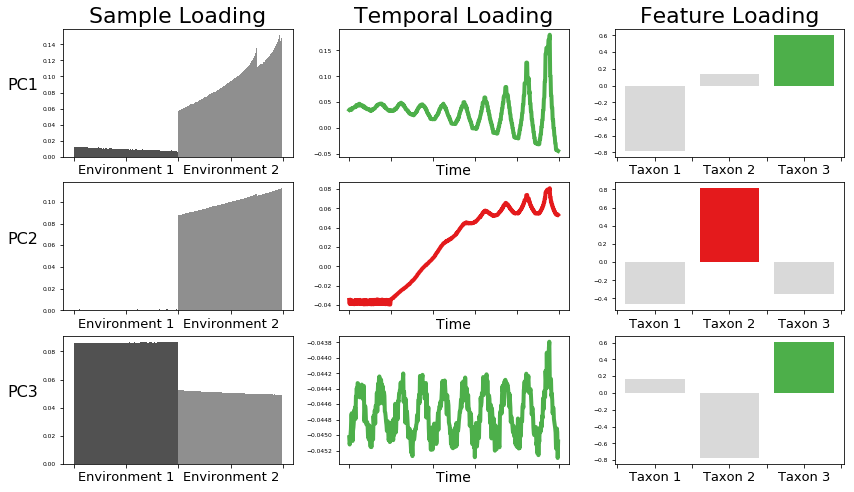

In [352]:

fig,axn = plt.subplots(3,3,figsize=(14,8))
i = 0
axn = axn.flat

color_sig = {0:'#4daf4a',1:'#e41a1c',2:'#4daf4a'}
colot_feat = {0:['#d9d9d9','#d9d9d9','#4daf4a'],
              1:['#d9d9d9','#e41a1c','#d9d9d9'],
              2:['#d9d9d9','#d9d9d9','#4daf4a']}
color_samp = ['#252525']*100 + ['#737373']*100

for pc in range(3):
    
    axn[i].bar(tload.index.values,abs(tload[pc].values),width=1,
               color=color_samp,alpha=.8)
    axn[i].set_xticklabels(['','','Environment 1',''
                            ,'Environment 2',''],fontsize=13)
    axn[i].set_ylabel('PC'+str(pc+1),fontsize=16,rotation=0,labelpad=20)
    axn[i].tick_params(axis='y', which='both', labelsize=6)
    if pc==0:
        axn[i].set_title('Sample Loading',fontsize=22)
    i+=1
    
    if pc==1:
        axn[i].plot(tsamp.index.values,tsamp[pc].values*-1,lw=4,c=color_sig[pc])
    else:
        axn[i].plot(tsamp.index.values,tsamp[pc].values,lw=4,c=color_sig[pc])
    axn[i].set_xticklabels([])
    axn[i].set_xlabel('Time',fontsize=14,labelpad=0)
    axn[i].tick_params(axis='y', which='both', labelsize=6)
    if pc==0:
        axn[i].set_title('Temporal Loading',fontsize=22)
    i+=1
     
    if pc!=0:
        axn[i].bar(tfeat.index.values,tfeat[pc].values,
                   color=colot_feat[pc])
    else:
        axn[i].bar(tfeat.index.values,tfeat[pc].values*-1,
                   color=colot_feat[pc])
    axn[i].set_xticklabels(['','','Taxon 1','','Taxon 2','','Taxon 3',''],fontsize=13)
    axn[i].tick_params(axis='y', which='both', labelsize=6)
    if pc==0:
        axn[i].set_title('Feature Loading',fontsize=22)
    i+=1

plt.savefig('figures/figure1C_loadings.png',dpi=300, 
            bbox_inches='tight', facecolor='white')
plt.show()


